![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Project Title

## Overview

We are taking housing data from King's County, Washington. This data has approximately 20 thousand entries, with each row representing a home sale. The entires include the sale price of each home, as well as other features, such as Sqaure fottage of living area, overall condition, zipcode etc. 

## Business Problem

We have been hired by a developer to find out what factors indicate that a home will sell for a large amount. They want to build single family homes like the ones in our dataset and need to know which attributes to focus on. The variables most associated with home price are those that are the most important for the developer to invest in. 


## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

### Importing relevant libraries, as well as our data 

In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from util import run_model 
from util import evaluate_model

pd.set_option('display.max_columns',None)
data = pd.read_csv('kc_house_data.csv')

### Taking an initial look at our dataframe

In [4]:
#data.info()

In [5]:

data['price'] = data['price'].map(lambda x: np.log(x))
data.price


0        12.309982
1        13.195614
2        12.100712
3        13.311329
4        13.142166
           ...    
21592    12.793859
21593    12.899220
21594    12.904459
21595    12.899220
21596    12.691580
Name: price, Length: 21597, dtype: float64

### Seperating our data into train and test groups 

In [6]:
y = data['price']
X = data.drop('price', axis=1)

# Split the data out, specifying size of the split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=5)

#Join the dataframes back together 
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

### Looking at the correlations of price vs each column 

In [7]:
#sns.pairplot(data_train)
#plt.show()
#fig, ax = plt.subplots(figsize=(18,10))
#sns.heatmap(data_train.corr(), annot=True, ax=ax)
#data_train.corr().price.sort_values(ascending=False)

### One-Hot Encoding the waterfront column

In [8]:
def waterfront_cleanup(df, column_name):
    df['on_the_water'] = df[column_name]
    df.loc[ df['on_the_water'] != 1, ['on_the_water']] = 0
    df.loc[ df['on_the_water'] != 0, ['on_the_water']] = 1

waterfront_cleanup(data_train, 'waterfront')
data_train.on_the_water.value_counts()


0.0    17153
1.0      124
Name: on_the_water, dtype: int64

### Grouping our data by zipcode, and sorting by average house price

In [9]:
def zipcode_sorter(df):
    return df.groupby('zipcode')['price'].mean().round().sort_values(ascending=False)

#zipcode_sorter(data_train)

### One-Hot encoding zipcodes

In [22]:
pd.set_option('display.max_columns', None)
#from sklearn.preprocessing import OneHotEncoder

#def zipcode_encoder(df):
    #zipcodes = df[['zipcode']]
    #ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
   # ohe.fit(zipcodes)
    #encoded_zipcodes = ohe.transform(zipcodes)
    #zipcodes = list(ohe.categories_[0])
   # encoded_zipcodes_df = pd.DataFrame(encoded_zipcodes, 
                                       #columns=ohe.get_feature_names(['zipcode']),
                                       #index = df.index)
    #return encoded_zipcodes_df

    
#data_train =  pd.concat([data_train, zipcode_encoder(data_train)], axis=1)
#data_test =  pd.concat([data_test, zipcode_encoder(data_test)], axis=1)

zipcodes = []
def zipcode_encoder(df):
    for i in list(set(df['zipcode'])):
        data_train.loc[data_train['zipcode'] == i, 'zip_' + str(i)] = 1
        data_train.loc[data_train['zipcode'] != i, 'zip_' + str(i)] = 0
        
        data_test.loc[data_test['zipcode'] == i, 'zip_' + str(i)] = 1
        data_test.loc[data_test['zipcode'] != i, 'zip_' + str(i)] = 0
        
        zipcodes.append('zip_' + str(i))

zipcode_encoder(data_test)

        
data_test.head()
#print(zipcodes)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,zip_98177,zip_98178,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98188,zip_98065,zip_98070,zip_98198,zip_98072,zip_98199,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98039,zip_98125,zip_98126,zip_98040,zip_98001,zip_98002,zip_98003,zip_98004,zip_98133,zip_98006,zip_98005,zip_98136,zip_98008,zip_98010,zip_98011,zip_98007,zip_98014,zip_98144,zip_98146,zip_98019,zip_98148,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98155,zip_98030,zip_98031,zip_98029,zip_98033,zip_98034,zip_98032,zip_98166,zip_98038,zip_98168,zip_98042,zip_98045,neighborhood,Vashon,White_Center,Auburn,Kenmore,Tukwila,Sammamish,SeaTac,Maple_Valley,Federal_Way,Bryn_Mawr_Skyway,Shoreline,Enumclaw,Woodinville,Issaquah,North_Bend,Mercer_Island,Medina,Des_Moines,Kirkland,Renton,Carnation,East_Hill_Meridian,Fall_City,Cottage_Lake,Redmond,Seattle,Bothell,Lakeland_North,Black_Diamond,Snoqualmie,Kent,Burien,Fairwood,Bellevue,Duvall,Covington,Union_Hill_Novelty_Hill
15393,104560280,5/22/2014,4,3.00,1990,6180,2.0,NaN,0.0,3,7,1990,0.0,1990,0.0,98023,47.3083,-122.360,1910,6180,12.517227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Federal_Way,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6035,1725059316,11/20/2014,4,4.00,6330,13296,2.0,0.0,2.0,3,13,4900,1430.0,2000,0.0,98033,47.6488,-122.201,2200,9196,14.686804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Kirkland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12871,3861470120,11/26/2014,4,2.75,4270,25807,2.0,0.0,0.0,3,11,4270,0.0,1996,0.0,98004,47.5951,-122.206,3860,20723,14.291745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bellevue,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21099,7853361310,12/15/2014,4,2.50,1950,5000,2.0,0.0,0.0,3,8,1950,0.0,2012,0.0,98065,47.5150,-121.872,2710,5000,12.959844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Snoqualmie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11629,3834000004,3/2/2015,2,1.50,1150,7552,1.0,0.0,1.0,3,7,1150,0.0,1944,0.0,98125,47.7298,-122.286,1910,8145,12.765688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Seattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### One-Hot Encoding Neighborhoods

In [11]:
zipcode_dict = {98002: 'Auburn',98092: 'Auburn',98224: 'Baring',98004: 'Bellevue',98005: 'Bellevue',
98006: 'Bellevue',98007: 'Bellevue',98008: 'Bellevue',98010: 'Black_Diamond',98011: 'Bothell',
98178: 'Bryn_Mawr_Skyway',98148: 'Burien',98166: 'Burien',98014: 'Carnation',98077: 'Cottage_Lake',
98042: 'Covington',98198: 'Des_Moines',98019: 'Duvall',98031: 'East_Hill_Meridian',98022: 'Enumclaw',
98058: 'Fairwood',98024: 'Fall_City',98003: 'Federal_Way',98023: 'Federal_Way',98027: 'Issaquah',
98029: 'Issaquah',98028: 'Kenmore',98032: 'Kent',98030: 'Kent',98033: 'Kirkland',98034: 'Kirkland',
98001: 'Lakeland_North',98038: 'Maple_Valley',98039: 'Medina',98040: 'Mercer_Island',98045: 'North_Bend',
98047: 'Pacific',98050: 'Preston',98051: 'Ravensdale',98052: 'Redmond',98055: 'Renton',98056: 'Renton',
98057: 'Renton',98059: 'Renton',98074: 'Sammamish',98075: 'Sammamish',98188: 'SeaTac',98199: 'Seattle',
98174: 'Seattle',98154: 'Seattle',98158: 'Seattle',98164: 'Seattle',98101: 'Seattle',98102: 'Seattle',
98103: 'Seattle',98104: 'Seattle',98105: 'Seattle',98106: 'Seattle',98107: 'Seattle',98108: 'Seattle',
98109: 'Seattle',98112: 'Seattle',98115: 'Seattle',98116: 'Seattle',98117: 'Seattle',98118: 'Seattle',
98119: 'Seattle',98121: 'Seattle',98122: 'Seattle',98125: 'Seattle',98126: 'Seattle',98133: 'Seattle',
98134: 'Seattle',98136: 'Seattle',98144: 'Seattle',98155: 'Shoreline',98177: 'Shoreline',98288: 'Skykomish',
98065: 'Snoqualmie',98168: 'Tukwila',98053: 'Union_Hill_Novelty_Hill',98195: 'Univ_Of_Washington',
98070: 'Vashon',98146: 'White_Center',98072: 'Woodinville'}



for i in zipcode_dict.keys():
    data_train.loc[data_train['zipcode'] == i, 'neighborhood'] = zipcode_dict[i] 
    data_test.loc[data_test['zipcode'] == i, 'neighborhood'] = zipcode_dict[i] 

neighborhood_list = list(set(data_train['neighborhood']))

for i in neighborhood_list:
    data_train.loc[data_train['neighborhood'] == i, i] = 1
    data_train.loc[data_train['neighborhood'] != i, i] = 0

for i in neighborhood_list:
    data_test.loc[data_test['neighborhood'] == i, i] = 1
    data_test.loc[data_test['neighborhood'] != i, i] = 0

data_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,on_the_water,zip_98177,zip_98178,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98188,zip_98065,zip_98070,zip_98198,zip_98072,zip_98199,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98039,zip_98125,zip_98126,zip_98040,zip_98001,zip_98002,zip_98003,zip_98004,zip_98133,zip_98006,zip_98005,zip_98136,zip_98008,zip_98010,zip_98011,zip_98007,zip_98014,zip_98144,zip_98146,zip_98019,zip_98148,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98155,zip_98030,zip_98031,zip_98029,zip_98033,zip_98034,zip_98032,zip_98166,zip_98038,zip_98168,zip_98042,zip_98045,neighborhood,Vashon,White_Center,Auburn,Kenmore,Tukwila,Sammamish,SeaTac,Maple_Valley,Federal_Way,Bryn_Mawr_Skyway,Shoreline,Enumclaw,Woodinville,Issaquah,North_Bend,Mercer_Island,Medina,Des_Moines,Kirkland,Renton,Carnation,East_Hill_Meridian,Fall_City,Cottage_Lake,Redmond,Seattle,Bothell,Lakeland_North,Black_Diamond,Snoqualmie,Kent,Burien,Fairwood,Bellevue,Duvall,Covington,Union_Hill_Novelty_Hill
2744,2472920140,4/3/2015,4,2.50,2620,9359,2.0,0.0,0.0,3,9,2620,0.0,1987,0.0,98058,47.4380,-122.152,2580,7433,12.911642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fairwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8025,6021500025,8/18/2014,3,1.75,2360,4063,1.0,0.0,0.0,5,7,1180,1180.0,1940,0.0,98117,47.6902,-122.382,1660,4063,13.356249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Seattle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13314,7852130720,10/9/2014,3,2.50,2240,7791,2.0,0.0,0.0,3,7,2240,0.0,2002,0.0,98065,47.5361,-121.880,2480,5018,13.022543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Snoqualmie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8085,1924059029,6/17/2014,5,6.75,9640,13068,1.0,1.0,4.0,3,12,4820,4820.0,1983,2009.0,98040,47.5570,-122.210,3270,10454,15.356670,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mercer_Island,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10303,4154304740,2/24/2015,3,2.75,2780,7200,1.5,0.0,0.0,4,8,1870,910.0,1913,0.0,98118,47.5632,-122.270,1700,7200,13.471611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Seattle,0.0,0.0,0.0,0.0,0.0,0.0,0.

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze the data to arrive at an initial approach?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

### Simple Model 

Our simple model is just square footage of living space plotted against price, as that was the variable with the strongest correlation to price. 

In [12]:
simple_formula = 'price ~ sqft_living'
simple_model = ols(formula=simple_formula, data=data_train).fit()
results= simple_model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                 1.601e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:33:45   Log-Likelihood:                -7742.8
No. Observations:               17277   AIC:                         1.549e+04
Df Residuals:                   17275   BIC:                         1.551e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2214      0.007   1710.590      0.000      12.207      12.235
sqft_living     0.0004   3.15e-06    126.514      0.000       0.000       0.000
==============================================================================
Omnibus:                        2.638   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                2.622
Skew:                           0.030   Prob(JB):                        0.269
Kurtosis:                       3.009   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Defining functions to create model formulas with zipcodes and neighborhoods

In [13]:
neighborhoods = list(set(zipcode_dict.values()))

def zipcode_formula_builder(df, lst):
    zipcodes = list(set(df['zipcode']))
    zipcode_formula = 'price ~ '
    for i in zipcodes:
        zipcode_formula += '{} + '.format(str(i))
    for i in lst:
        zipcode_formula += '{} + '.format(str(i))
    zipcode_formula = zipcode_formula[:-2]
    return zipcode_formula

def zipcode_column_builder(df, lst):
    columns = lst
    for i in zipcodes:
        columns.append(str(i))
    return columns

def neighborhood_column_builder(df, lst):
    columns = lst
    for i in neighborhoods:
        columns.append(str(i))
    return columns


def neighborhood_formula_builder(df, lst):
    neighborhoods = list(set(df['neighborhood']))
    neighborhood_formula = 'price ~ '
    for i in neighborhoods:
        neighborhood_formula += '{} + '.format(str(i))
    for i in lst:
        neighborhood_formula += '{} + '.format(str(i))
    neighborhood_formula = neighborhood_formula[:-2]
    return neighborhood_formula

#print(zipcode_formula_builder(data_train, ['sqft_living', 'grade']))
#print()
#print(neighborhood_formula_builder(data_train, ['sqft_living', 'grade']))
print(zipcode_column_builder(data_train, ['sqft_living', 'grade', 'condition']))
print()
print(neighborhood_column_builder(data_train, ['sqft_living', 'grade']).pop(-1))

['sqft_living', 'grade', 'condition', 'zip_98177', 'zip_98178', 'zip_98052', 'zip_98053', 'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059', 'zip_98188', 'zip_98065', 'zip_98070', 'zip_98198', 'zip_98072', 'zip_98199', 'zip_98074', 'zip_98075', 'zip_98077', 'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105', 'zip_98106', 'zip_98107', 'zip_98108', 'zip_98109', 'zip_98112', 'zip_98115', 'zip_98116', 'zip_98117', 'zip_98118', 'zip_98119', 'zip_98122', 'zip_98039', 'zip_98125', 'zip_98126', 'zip_98040', 'zip_98001', 'zip_98002', 'zip_98003', 'zip_98004', 'zip_98133', 'zip_98006', 'zip_98005', 'zip_98136', 'zip_98008', 'zip_98010', 'zip_98011', 'zip_98007', 'zip_98014', 'zip_98144', 'zip_98146', 'zip_98019', 'zip_98148', 'zip_98022', 'zip_98023', 'zip_98024', 'zip_98027', 'zip_98028', 'zip_98155', 'zip_98030', 'zip_98031', 'zip_98029', 'zip_98033', 'zip_98034', 'zip_98032', 'zip_98166', 'zip_98038', 'zip_98168', 'zip_98042', 'zip_98045']

Union_Hill_Novelty_Hill


### Generating a model using just zipcodes

In [20]:
model_columns = zipcode_column_builder(data_test, ['sqft_living', 'grade'])
model = run_model(data_train, data_test, model_columns)
model_summ = model[0].summary()
#model_summ
print(zipcode_column_builder(data_train, []))

['zip_98177', 'zip_98178', 'zip_98052', 'zip_98053', 'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059', 'zip_98188', 'zip_98065', 'zip_98070', 'zip_98198', 'zip_98072', 'zip_98199', 'zip_98074', 'zip_98075', 'zip_98077', 'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105', 'zip_98106', 'zip_98107', 'zip_98108', 'zip_98109', 'zip_98112', 'zip_98115', 'zip_98116', 'zip_98117', 'zip_98118', 'zip_98119', 'zip_98122', 'zip_98039', 'zip_98125', 'zip_98126', 'zip_98040', 'zip_98001', 'zip_98002', 'zip_98003', 'zip_98004', 'zip_98133', 'zip_98006', 'zip_98005', 'zip_98136', 'zip_98008', 'zip_98010', 'zip_98011', 'zip_98007', 'zip_98014', 'zip_98144', 'zip_98146', 'zip_98019', 'zip_98148', 'zip_98022', 'zip_98023', 'zip_98024', 'zip_98027', 'zip_98028', 'zip_98155', 'zip_98030', 'zip_98031', 'zip_98029', 'zip_98033', 'zip_98034', 'zip_98032', 'zip_98166', 'zip_98038', 'zip_98168', 'zip_98042', 'zip_98045']


Train R2: 0.848
Test R2: 0.848
****
Train RMSE: 0
Test RMSE: 0
****
Train MAE: 0
Test MAE: 0

Residual scatter plot:


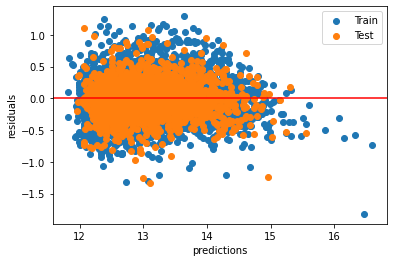



Residual qq plot


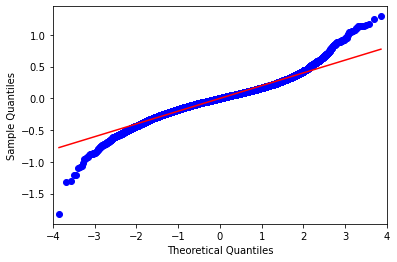

In [21]:
model_columns_1 = zipcode_column_builder(data_test, ['sqft_living', 'yr_built', 'grade'])
model = run_model(data_train, data_test, model_columns_1)
model_summ = model[0].summary()


model_summ
#evaluate_model(data_train, data_test, model_columns_1)

cols = model_columns_1
formula = 'price ~ ' + ' + '.join(cols)
model_2 = ols(formula=formula, data = data_test).fit()
model_2_summ = model_2.summary()
model_2_summ

evaluate_model(data_train, data_test, model_columns_1)

In [14]:
model_columns = zipcode_column_builder(data_test, ['sqft_living', 'grade', 'yr_built'])
model = run_model(data_train, data_test, model_columns)
model_summ = model[0].summary()
#model_summ


In [15]:
model_columns = zipcode_column_builder(data_test, [ 'grade', 'yr_built'])
model = run_model(data_train, data_test, model_columns)
model_summ = model[0].summary()

#evaluate_model(data_train, data_test, model_columns)

In [16]:
model_columns = zipcode_column_builder(data_test, ['sqft_living',  'yr_built'])
model = run_model(data_train, data_test, model_columns)
model_summ = model[0].summary()
#model_summ

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [17]:
# code here to arrive at a baseline prediction

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [18]:
# code here for your first 'substandard' model

In [19]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [20]:
# code here to iteratively improve your models

In [21]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [22]:
# code here to show your final model

In [23]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
